In [87]:
! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git -q
! git clone https://github.com/maussn/GRS34806-project.git -q

Cloning into 'grs34806-deep-learning-project-data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21 (from 1)
Receiving objects: 100% (21/21), 8.74 MiB | 5.77 MiB/s, done.
Cloning into 'GRS34806-project'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 58 (delta 21), reused 31 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 94.53 KiB | 4.73 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import sys
import os
from pathlib import Path
import random
import seaborn as sns

In [89]:
os.chdir(Path('grs34806-deep-learning-project-data'))

In [121]:
def read(seqfile: str, posfile: str) -> tuple[list, list]:
    """Read file with sequences and file with positive cases into lists.

    :param seqfile: file with sequences
    :type seqfile: str
    :param posfile: file with positive cases (annotated with function)
    :type posfile: str
    :return: two lists, first with sequences and second with boolean labels
    :rtype: tuple[list, list]
    """
    idlist = []
    datalist = []
    labellist = []
    with open(seqfile, 'r') as f:
        for line in f.readlines():
            line = line.rstrip().split('\t')
            idlist.append(line[0])
            datalist.append(line[1])
            labellist.append(False)
    with open(posfile, 'r') as f:
        for line in f.readlines():
            id = line.rstrip()
            try:
                i = idlist.index(id)
                labellist[i] = True
            except ValueError:
                continue
    return datalist, labellist


def split_labelled(datalist: list, labellist: list):
    pos_datalist = []
    neg_datalist = []
    for i, label in enumerate(labellist):
        if label:
            pos_datalist.append(datalist[i])
        else:
            neg_datalist.append(datalist[i])
    return pos_datalist, neg_datalist


def remove_sequences(datalist: list, fraction=0.5):
    random.shuffle(datalist)
    i = round(len(datalist) * fraction)
    return datalist[:i]


def fuse_sequence_lists(pos_datalist: list, neg_datalist: list):
    pos_labels = [True for _ in pos_datalist]
    neg_labels = [False for _ in neg_datalist]
    datalist = pos_datalist + neg_datalist
    labellist = pos_labels + neg_labels
    return datalist, labellist


def generate_train_test(datalist: list, labellist: list, fraction: float=0.8):
    """Split up dataset in training set and test set

    :param datalist: list with sequences
    :type datalist: list
    :param labellist: list with labels
    :type labellist: list
    :param ratio: fraction to be added to the training set, remainder is added to the test set, defaults to 0.8
    :type ratio: float, optional
    :return: four lists, first two the training data and labels, second two the test data and labels
    :rtype: tuple[list, list, list, list]
    """
    c = list(zip(datalist, labellist))
    random.shuffle(c)
    datalist[:], labellist[:] = zip(*c)
    i = round(len(datalist) * fraction)
    traindatalist = datalist[:i]
    trainlabellist = labellist[:i]
    testdatalist = datalist[i:]
    testlabellist = labellist[i:]
    return traindatalist, trainlabellist,testdatalist,testlabellist


def tokenize(data: list, map2num: dict, non_aa_num: int=20) -> list:
    """Tokenize all sequences in a list

    :param data: list of sequences to tokenize
    :type data: list
    :param map2num: ammino acid -> integer token mapping
    :type map2num: dict
    :param non_aa_num: token for non amino acid characters, defaults to 20
    :type non_aa_num: int, optional
    :return: list of tokenized sequences
    :rtype: list
    """
    seq = []
    for count, i in enumerate(data):
        seq.append([map2num.get(j,non_aa_num) for j in list(i)])
    return seq


def truncate_pad(line: list, num_steps: int, padding_token: int) -> list:
    """Truncate or pad a tokenized sequence

    :param line: tokenized sequence
    :type line: list
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param padding_token: token to be used for padding
    :type padding_token: int
    :return: truncated/padded sequence
    :rtype: list
    """
    if len(line) > num_steps:
        return line[:num_steps] # Truncate
    return line + [padding_token] * (num_steps - len(line)) # Pad


def build_seq_array(lines: list, num_steps: int, non_aa_num: int=20) -> torch.tensor:
    """Truncate or pad tokenized sequences and convert to tensor

    :param lines: tokenized sequences
    :type lines: list
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param non_aa_num: token for padding, defaults to 20
    :type non_aa_num: int, optional
    :return: tensor with truncated/padded tokenized sequences
    :rtype: torch.tensor
    """
    return torch.tensor([truncate_pad(l, num_steps, non_aa_num) for l in lines], dtype=torch.long)


def load_array(data_arrays: tuple[torch.tensor, torch.tensor], batch_size: int, is_train: bool=True) -> torch.utils.data.DataLoader:
    """Construct a PyTorch data iterator.

    Taken from d2l package"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)


def load_data(batch_size: int, num_steps: int, dataset: tuple[list, list]) -> torch.utils.data.DataLoader:
    """Tokenize sequence/label dataset and load into dataloader.

    :param batch_size: size of each batch
    :type batch_size: int
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param dataset: first list contains sequences, second labels
    :type dataset: tuple[list, list]
    :return: torch dataloader which gives a tensor of sequences in a batch and a tensor with their labels
    :rtype: torch.utils.data.DataLoader
    """
    mapaa2num = {aa: i for (i, aa) in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
    seq,lab = dataset
    seq = tokenize(seq, mapaa2num)
    seq_array = build_seq_array(seq, num_steps)
    data_arrays = (seq_array, torch.tensor(lab, dtype=torch.long))
    data_iter = load_array(data_arrays, batch_size)
    return data_iter

In [138]:
batch_size = 10
num_steps = 500

# Example for one of the simulated datasets
datalist, labellist = read("len200_500_n5000nr4.seq", "len200_500_n5000nr4.pos")

# Remove negatives
pos_datalist, neg_datalist = split_labelled(datalist, labellist)
neg_datalist = remove_sequences(neg_datalist, 0.5)
datalist, labellist = fuse_sequence_lists(pos_datalist, neg_datalist)

traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist, 0.8)
traindataset = [traindatalist, trainlabellist]
testdataset = [testdatalist, testlabellist]

# Set batch_size and num_steps (maximum sequence length)
train_iter = load_data(batch_size, num_steps, traindataset)
test_iter = load_data(batch_size, num_steps, testdataset)

print(next(iter(train_iter)))

[tensor([[10, 18, 17,  ..., 20, 20, 20],
        [10, 17, 17,  ..., 20, 20, 20],
        [10,  3, 10,  ..., 20, 20, 20],
        ...,
        [10, 14,  1,  ..., 20, 20, 20],
        [10, 19, 18,  ..., 20, 20, 20],
        [10,  2,  9,  ..., 20, 20, 20]]), tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 1])]


<Axes: ylabel='Count'>

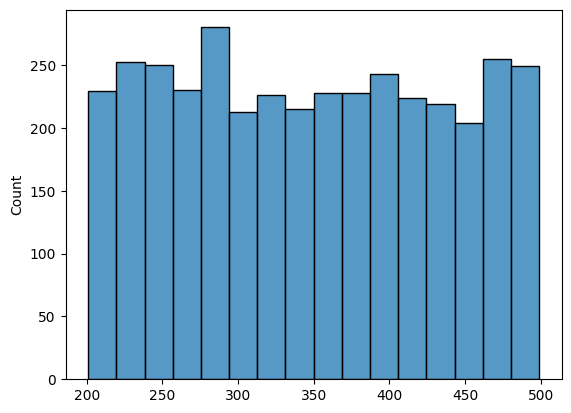

In [139]:
len_list = []
for s in datalist:
    len_list.append(len(s))
sns.histplot(len_list)

In [140]:
p = 0
n = 0
for l in labellist:
    if l:
        p += 1
    else:
        n+=1
print(f'{p = }\n{n = }')

p = 2490
n = 1255


In [114]:
print(datalist[5:10])
print(labellist[5:10])

split_labelled(datalist[5:10], labellist[5:10])

['MPKKLLLLPPPSASSAFRVPRARPVPPPAMNAARTGYRVFSANSTAACTELAKRITERLGAELGKSVVYQETNGETRVEIKESVRGQDIFIIQTIPRDVNTAVMELLIMAYALKTACARNIIGVIPYFPYSKQSKMRKRGSIVCKLLASMLAKAGLTHIITMDLHQKEIQGFFSFPVDNLRASPFLLQYIQEEIPNYRNAVIVAKSPDAAKRAQSYAERLRLGLAVIHGEAQCTELDMDDGRHSPPMVKNATVHPGLELPLMMAKEKPPITVVGDVGGRIAIIVDDIIDDVESFVAAAEILKERGAYKIYVMATHGILSAEAPRLIEESSVDEVVVTNTVPHEVQKLQCPKIKTVDISLILSEAIRRIHNGESMAYLFRNITVDD', 'MPRGSRSRTSRMAPPASRAPQMRAAPRPAPVAQPPAAAPPSAVGSSAAAPRQPGLMAQMATTAAGVAVGSAVGHTLGHAITGGFSGGSNAEPARPDITYQEPQGTQPAQQQQPCLYEIKQFLECAQNQGDIKLCEGFNEVLKQCRLANGLA', 'MWFMYLLSWLSLFIQVAFITLAVAAGLYYLAELIEEYTVATSRIIKYMIWFSTAVLIGLYVFERFPTSMIGVGLFTNLVYFGLLQTFPFIMLTSPNFILSCGLVVVNHYLAFQFFAEEYYPFSEVLAYFTFCLWIIPFAFFVSLSAGENVLPSTMQPGDDVVSNYFTKGKRGKRLGILVVFSFIKEAILPSRQKIY', 'MEDSMDMDMSPLRPQNYLFGCELKADKDYHFKVDNDENEHQLSLRTVSLGAGAKDELHIVEAEAMNYEGSPIKVTLATLKMSVQPTVSLGGFEITPPVVLRLKCGSGPVHISGQHLVAVEEDAESEDEEEEDVKLLSISGKRSAPGGGSKVPQKKVKLAADEDDDDDDEEDDDEDDDDDDFDDEEAEEKAPVKKSIRDTPAKNAQKSNQNGKDSKPSSTPRSKGQESFKKQEKTPKTPKGPSSVEDIKAKMQAS

(['MPRGSRSRTSRMAPPASRAPQMRAAPRPAPVAQPPAAAPPSAVGSSAAAPRQPGLMAQMATTAAGVAVGSAVGHTLGHAITGGFSGGSNAEPARPDITYQEPQGTQPAQQQQPCLYEIKQFLECAQNQGDIKLCEGFNEVLKQCRLANGLA'],
 ['MPKKLLLLPPPSASSAFRVPRARPVPPPAMNAARTGYRVFSANSTAACTELAKRITERLGAELGKSVVYQETNGETRVEIKESVRGQDIFIIQTIPRDVNTAVMELLIMAYALKTACARNIIGVIPYFPYSKQSKMRKRGSIVCKLLASMLAKAGLTHIITMDLHQKEIQGFFSFPVDNLRASPFLLQYIQEEIPNYRNAVIVAKSPDAAKRAQSYAERLRLGLAVIHGEAQCTELDMDDGRHSPPMVKNATVHPGLELPLMMAKEKPPITVVGDVGGRIAIIVDDIIDDVESFVAAAEILKERGAYKIYVMATHGILSAEAPRLIEESSVDEVVVTNTVPHEVQKLQCPKIKTVDISLILSEAIRRIHNGESMAYLFRNITVDD',
  'MWFMYLLSWLSLFIQVAFITLAVAAGLYYLAELIEEYTVATSRIIKYMIWFSTAVLIGLYVFERFPTSMIGVGLFTNLVYFGLLQTFPFIMLTSPNFILSCGLVVVNHYLAFQFFAEEYYPFSEVLAYFTFCLWIIPFAFFVSLSAGENVLPSTMQPGDDVVSNYFTKGKRGKRLGILVVFSFIKEAILPSRQKIY',
  'MEDSMDMDMSPLRPQNYLFGCELKADKDYHFKVDNDENEHQLSLRTVSLGAGAKDELHIVEAEAMNYEGSPIKVTLATLKMSVQPTVSLGGFEITPPVVLRLKCGSGPVHISGQHLVAVEEDAESEDEEEEDVKLLSISGKRSAPGGGSKVPQKKVKLAADEDDDDDDEEDDDEDDDDDDFDDEEAEEKAPVKKSIRDTPAKNAQKSNQNGKDSKPSSTPRSKGQESFKKQEKTPKTPKGPSSVED

In [92]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv1d:
        nn.init.xavier_uniform_(layer.weight)


class Trainer:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer


    def _train_one_epoch(self, epoch_index, train_iter):
        result_loss = 0
        for i, (inputs, labels) in enumerate(train_iter):
            self.optimizer.zero_grad()

            outputs = self.model(inputs)

            loss = self.loss_fn(outputs, labels)
            loss.backward()

            self.optimizer.step()
            result_loss += loss.item()
        return result_loss / (i + 1)


    def train(self, epochs, train_iter, test_iter):
        for epoch in range(epochs):
            self.model.train(True)
            train_loss = self._train_one_epoch(epoch, train_iter)
            self.model.eval()
            result_loss = 0
            with torch.no_grad():
                for i, (test_inputs, test_labels) in enumerate(test_iter):
                    test_outputs = self.model(test_inputs)
                    loss = self.loss_fn(test_outputs, test_labels)
                    # print(f'{loss = }\t{test_outputs = }\t{test_labels = }')
                    result_loss += loss.item()
            test_loss = result_loss / (i + 1)
            print(f'{epoch = }\t{train_loss=:.5f}\t{test_loss=:.5f}')



In [ ]:
class MinimalGOClassifierCNN(nn.Module):
    def __init__(self, input_length: int, vocab_size : int=21,  num_filters: int=32, kernel_size: int=5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size)
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=vocab_size, out_channels=num_filters, kernel_size=kernel_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier = nn.Sequential(
            nn.LazyLinear(out_features=2)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.conv_layer(x.transpose(1,2))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        output = F.softmax(x, 1)
        return output

In [106]:
class BerryCNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, context_size: int, vocab_size: int = 21,  conv_channels: int = 128, use_bias: bool = False):
        super().__init__()
        assert context_size % 2 == 0, f'Invalid context_size, {context_size} is not an even number'

        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # CNN model for binary classification
        self.conv1 = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.fc = nn.Sequential(
            # flatten + classification head
            nn.Flatten(1, -1),
            nn.LazyLinear(out_features=2, bias=use_bias)  # binary classification
        )


    def forward(self, x: torch.tensor, targets: torch.tensor = None):
        """Predict protein function class (0 or 1)"""
        x = self.embedding(x).permute(0,2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        return self.fc(x)


In [ ]:
class BerryCNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, context_size: int, vocab_size: int = 21,  conv_channels: int = 128, use_bias: bool = False):
        super().__init__()
        assert context_size % 2 == 0, f'Invalid context_size, {context_size} is not an even number'

        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # CNN model for binary classification
        self.conv1 = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            # conv block 2
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            # conv block 3
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.fc = nn.Sequential(
            # flatten + classification head
            nn.Flatten(1, -1),
            nn.LazyLinear(out_features=2, bias=use_bias)  # binary classification
        )


    def forward(self, x: torch.tensor, targets: torch.tensor = None):
        """Predict protein function class (0 or 1)"""
        x = self.embedding(x).permute(0,2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.fc(x)

In [141]:
model = BerryCNN1D(context_size=num_steps, conv_channels=128)
model.apply(init_weights)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model

BerryCNN1D(
  (embedding): Embedding(21, 21)
  (conv1): Sequential(
    (0): Conv1d(21, 128, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): ReLU()
    (2): AdaptiveMaxPool1d(output_size=1)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=2, bias=False)
  )
)

In [142]:
trainer = Trainer(model, loss_fn, optimizer)
trainer.train(epochs=10, train_iter=train_iter, test_iter=test_iter)

epoch = 0	train_loss=0.66353	test_loss=0.62359
epoch = 1	train_loss=0.61548	test_loss=0.58779
epoch = 2	train_loss=0.44076	test_loss=0.26884
epoch = 3	train_loss=0.15181	test_loss=0.08044
epoch = 4	train_loss=0.05801	test_loss=0.03982
epoch = 5	train_loss=0.03467	test_loss=0.03949
epoch = 6	train_loss=0.02399	test_loss=0.02052
epoch = 7	train_loss=0.01860	test_loss=0.01459
epoch = 8	train_loss=0.01421	test_loss=0.01229
epoch = 9	train_loss=0.01173	test_loss=0.01094


In [37]:
print(len(train_iter))

160
